In [1]:
import xarray as xr 
import os
import torch
import botorch # library for Bayesian Optimisation research
from torch import nn # Neural Network Module
import pandas as pd
from pyDOE import lhs
import numpy as np
from sklearn.decomposition import PCA
from scipy.interpolate import NearestNDInterpolator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import gpytorch
from botorch.models import SingleTaskGP, FixedNoiseGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood   
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement
from botorch.acquisition import ProbabilityOfImprovement,UpperConfidenceBound,NoisyExpectedImprovement,ExpectedImprovement,qKnowledgeGradient,PosteriorMean
from botorch.optim import optimize_acqf
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils.sampling import manual_seed
from botorch.fit import fit_gpytorch_mll
SMOKE_TEST = os.environ.get("SMOKE_TEST")
device = "cuda" if torch.cuda.is_available() else "cpu" # Get cpu or gpu device for training
print(f'Running on PyTorch {torch.__version__}, Botorch {botorch.__version__}, using {device} device')
torch.set_default_dtype(torch.double)


c:\Users\Utente\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Running on PyTorch 1.13.0+cpu, Botorch 0.8.1, using cpu device


In [2]:
ds = xr.open_dataset("downloadERA-1yearEurope.nc")
ds.variables
ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')


# Select a random subset of 100 elements along the time dimension
n_elements = 100
random_indices = np.random.choice(ds.time.size, size=n_elements, replace=False)
ds = ds.sel(time=ds.time[random_indices])

In [3]:
# Convert to pandas DataFrame with multi-level index
df = ds.to_dataframe()

# Reset index to create single-level index
df = df.reset_index()

# Print DataFrame
df.head()

,longitude,latitude,time,t
0,-15.0,75.0,2004-01-30 03:00:00,252.747559
1,-15.0,75.0,2004-02-27 04:00:00,247.898926
2,-15.0,75.0,2004-01-08 10:00:00,255.965179
3,-15.0,75.0,2004-03-12 21:00:00,271.243744
4,-15.0,75.0,2004-01-21 12:00:00,253.037018


In [4]:
df["time"] = df["time"].astype(np.int64) * 1e-9
X_data  = np.vstack([df["longitude"].to_numpy().astype(np.float64) , 
                     df["latitude"].to_numpy().astype(np.float64) ,
                     df["time"].to_numpy().astype(np.float64) ]).T
                     
X_data = StandardScaler().fit_transform(X_data)
print('X_data shape',X_data.shape )
y_data = df["t"].to_numpy().reshape(-1,1)
y_data = StandardScaler().fit_transform( y_data)
print('y_data shape',y_data.shape )

data = np.vstack([X_data.T,y_data.T]).T

gnss_dataset = TensorDataset( torch.Tensor(X_data), torch.Tensor(y_data) )

hifi, lofi = train_test_split(data, test_size=2e-6, shuffle=True)
hifi, test = train_test_split(hifi, test_size=1e-1)

X_data shape (4181100, 3)
y_data shape (4181100, 1)


In [5]:
class TestcaseDataset(Dataset):
    def __init__(self):

        # Cast them
        self.X_hifi = torch.Tensor(hifi[:,:-1]) 
        self.X_lofi = torch.Tensor(lofi[:,:-1]) 
        self.X_test = torch.Tensor(test[:,:-1]) 
        self.Y_hifi = torch.Tensor(hifi[:,-1] ).unsqueeze(-1)
        self.Y_lofi = torch.Tensor(lofi[:,-1] ).unsqueeze(-1)
        self.Y_test = torch.Tensor(test[:,-1] ).unsqueeze(-1)

        self.hifi_dataset = TensorDataset(self.X_hifi, self.Y_hifi)
        self.test_dataset = TensorDataset(self.X_test, self.Y_test)

        def __call__(self):
           return self.hifi_dataset, self.test_dataset, self.X_hifi, self.X_lofi, self.X_test, self.Y_hifi, self.Y_lofi, self.Y_test


In [6]:
dataset = TestcaseDataset()

X_lofi = dataset.X_lofi
Y_lofi = dataset.Y_lofi
X_hifi = dataset.X_hifi
Y_hifi = dataset.Y_hifi
X_test = dataset.X_test
Y_test = dataset.Y_test
hifi_dataset = dataset.hifi_dataset
test_dataset = dataset.test_dataset

print("Shape of low fidelity  X and y: ",X_lofi.shape, Y_lofi.shape)
print("Shape of high fidelity X and y: ",X_hifi.shape, Y_hifi.shape)
print("Shape of test set      X and y: ",X_test.shape, Y_test.shape)
bounds = torch.Tensor([[X_data[:,0].min(), X_data[:,1].min(), X_data[:,2].min()], 
                       [X_data[:,0].max(), X_data[:,1].max(), X_data[:,2].max()]], 
                       dtype=torch.float32)
print("Buonds shape: ", bounds.shape)

# Create data loaders
hifi_dataloader = DataLoader(hifi_dataset, batch_size = 64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle=True)
best_obs_value = Y_hifi.numpy().max()

noise_level = 1e-1
noise = noise_level*torch.ones(X_lofi.shape[0])
lofi_dim = X_lofi.shape[0]

print('pts shape',X_data.shape)

Shape of low fidelity  X and y:  torch.Size([9, 3]) torch.Size([9, 1])
Shape of high fidelity X and y:  torch.Size([3762981, 3]) torch.Size([3762981, 1])
Shape of test set      X and y:  torch.Size([418110, 3]) torch.Size([418110, 1])
Buonds shape:  torch.Size([2, 3])
pts shape (4181100, 3)


In [7]:
# Define hyperparameters
n_samples, n_features = X_hifi.shape
input_size = n_features
hidden_size = 128
output_size = 1
learning_rate = 1e-2
# Define the neural network model (input, hidden, output size)
class NeuralNet(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(NeuralNet, self).__init__()
        # Define layers
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.LeakyReLU() # activation function nn.LeakyReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        #out = self.sigmoid(out)
        return out

In [8]:
nn_model = NeuralNet(input_size,hidden_size,output_size).to(device)
print(nn_model)

# Construct loss and optmizer 
criterion = nn.MSELoss() # Mean Square Error Loss # loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate) # from the optimization module

# In a single training epoch, the model makes predictions on the training dataset (fed to it in batches)
# and backpropagates the prediction error to update the model’s parameters

# Training loop:
#  - forward pass: compute predictions
#  - backward pass: gradients
#  - update weights
num_epochs = 3 if not SMOKE_TEST else 1 # epoch -> forward and backward of ALL training samples
for epoch in range(num_epochs):
    size = len(hifi_dataloader.dataset)
    nn_model.train()
    for batch, (X, y) in enumerate(hifi_dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = nn_model(X)         # prediction: forward pass
        loss = criterion(pred, y) # loss

        # Backpropagation
        optimizer.zero_grad()   # clears old gradients from the last step
        loss.backward()         # gradients: backward pass
        optimizer.step()        # update weights

    if (epoch+1) % 1 == 0:
            print(f"Epoch {epoch+1} / {num_epochs}, step [{batch+1}/{len(hifi_dataloader)}] loss: {loss:.4f}")
# Test       
size = len(test_dataloader.dataset)
num_batches = len(test_dataloader)
test_loss = 0
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = nn_model(X)
        test_loss += criterion(pred, y).item()
        
test_loss /= num_batches
print(f"Test Error -> Test loss: {test_loss:>8f} \n") # Acc: {acc:>8f}

def pred(new_point, model):
    with torch.no_grad():
            pred_point = model(new_point)
    return pred_point

NeuralNet(
  (linear1): Linear(in_features=3, out_features=128, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 1 / 3, step [58797/58797] loss: 0.1497
Epoch 2 / 3, step [58797/58797] loss: 0.1318
Epoch 3 / 3, step [58797/58797] loss: 0.2073
Test Error -> Test loss: 0.160385 



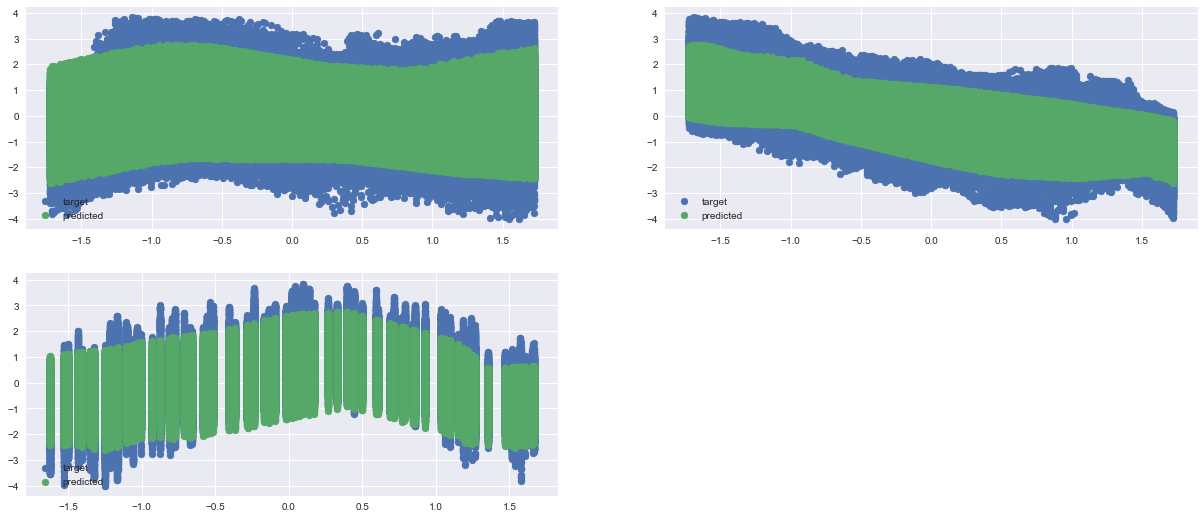

In [9]:
fig = plt.figure(figsize=(21, 9))
num_dim = round(X_data.shape[1]*.5)
Y_pred = pred(X_test, nn_model)
for alpha in range(X_data.shape[1]):
    
    ax = fig.add_subplot(num_dim, num_dim, alpha+1)
    ax.scatter(X_test[:,alpha].numpy(), Y_test.numpy(),label = 'target')
    ax.scatter(X_test[:,alpha].numpy(), Y_pred.numpy(),label = 'predicted')
    plt.legend(loc="lower left")
plt.show()

In [10]:
def initialize_model(X_lofi, Y_lofi, noise):
  X_lofi, Y_lofi = X_lofi.to(device), Y_lofi.to(device)
  likelihood = gpytorch.likelihoods.GaussianLikelihood(noise=noise, learn_additional_noise=False)
  single_model = SingleTaskGP(X_lofi, Y_lofi)
  #single_model = ExactGPModel(X_lofi.squeeze(), Y_lofi.squeeze(), likelihood)
  
  mll = ExactMarginalLogLikelihood(likelihood, single_model) # OTHER LIKELIHOOD ?
  return mll, single_model

In [11]:
def get_next_points(single_model, n_points=1, acqf_name="qNEI"):

  NUM_RESTARTS = 10 if not SMOKE_TEST else 2
  RAW_SAMPLES = 512 if not SMOKE_TEST else 4
  NUM_FANTASIES = 128 if not SMOKE_TEST else 4

  sampler = SobolQMCNormalSampler(RAW_SAMPLES)

  if acqf_name == "qNEI":
    acqf_name  = qNoisyExpectedImprovement(model = single_model, X_baseline = X_lofi, sampler=sampler )
  elif acqf_name == "qKG" :
    acqf_name  = qKnowledgeGradient(model = single_model, num_fantasies=NUM_FANTASIES)
  elif acqf_name == "EI":
    acqf_name  = ExpectedImprovement( model = single_model, best_f = best_obs_value )
  elif acqf_name == "qEI":
    acqf_name  = qExpectedImprovement( model = single_model, best_f = best_obs_value, sampler=sampler )
  elif acqf_name == "PI":
    acqf_name  = ProbabilityOfImprovement( model = single_model, best_f = best_obs_value )
  elif acqf_name == "UCB":
    acqf_name  = UpperConfidenceBound(model = single_model, beta=0.3)
  elif acqf_name == "qKG_proper" :
    qKG  = qKnowledgeGradient(model = single_model, num_fantasies=NUM_FANTASIES)
    argmax_pmean, max_pmean = optimize_acqf(
      acq_function=PosteriorMean(single_model), 
      bounds=bounds,
      q=1,
      num_restarts=10 if not SMOKE_TEST else 2,
      raw_samples=1024 if not SMOKE_TEST else 4,
    )
    acqf_name = qKnowledgeGradient(
      single_model,
      num_fantasies=NUM_FANTASIES,
      sampler=qKG.sampler,
      current_value=max_pmean,
    )
  else:
    raise RuntimeError("Unknown acquisition function name!")
 
  with manual_seed(1234):
    candidates, acq_value = optimize_acqf(
        acq_function=acqf_name, 
        bounds=bounds,
        q=n_points,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES
    )
  return candidates

In [12]:
N_ITER = 3 if not SMOKE_TEST else 1
X_lofi = X_lofi[0:lofi_dim]
Y_lofi = Y_lofi[0:lofi_dim]
for iter in range(N_ITER):
   mll, gp_model = initialize_model(X_lofi, Y_lofi, noise)
   fit_gpytorch_mll(mll)
   new_X = get_next_points(gp_model, n_points=8)  
   predicted_optimal_obj = pred(new_X, nn_model) 
   print(f"Iter {iter+1}/{N_ITER} - next points: {new_X}\n pred objectives: {predicted_optimal_obj}")
   X_lofi = torch.cat([X_lofi, new_X ])
   Y_lofi = torch.cat([Y_lofi, predicted_optimal_obj])
   best_obs_value = max(best_obs_value,Y_lofi.max())
   noise  = torch.cat([noise, 1e-3*torch.ones(new_X.shape[0]) ])

Iter 1/3 - next points: tensor([[ 1.2185, -0.7103,  0.5032],
        [-1.7246, -1.3906, -1.5964],
        [ 0.4484, -0.4643,  1.1709],
        [ 0.1165, -0.5098,  0.5404],
        [ 0.4989, -1.2225,  0.6939],
        [ 1.7246, -0.2717,  1.1975],
        [ 0.6747,  1.7225,  1.5746],
        [ 0.6183, -1.7225, -1.6114]])
 pred objectives: tensor([[ 1.1967],
        [ 0.5969],
        [ 0.0955],
        [ 1.0624],
        [ 1.4079],
        [-0.2338],
        [-1.1803],
        [ 0.5991]])
Iter 2/3 - next points: tensor([[-0.2350, -1.0575,  0.4663],
        [-1.2583, -0.6572,  0.3484],
        [ 0.3760, -1.2775,  0.3857],
        [-0.8424, -1.7225, -1.6225],
        [ 1.3069, -1.1034,  0.8191],
        [ 0.6346, -0.1777,  0.3807],
        [ 1.7246,  1.7225, -1.6225],
        [ 0.8313,  0.0123,  0.7144]])
 pred objectives: tensor([[ 1.7064],
        [ 1.2351],
        [ 1.8471],
        [ 1.0582],
        [ 1.3433],
        [ 1.0833],
        [-2.1542],
        [ 0.4353]])
Iter 3/3 - next 

In [13]:
print(round(X_data.shape[1]*.5))

2


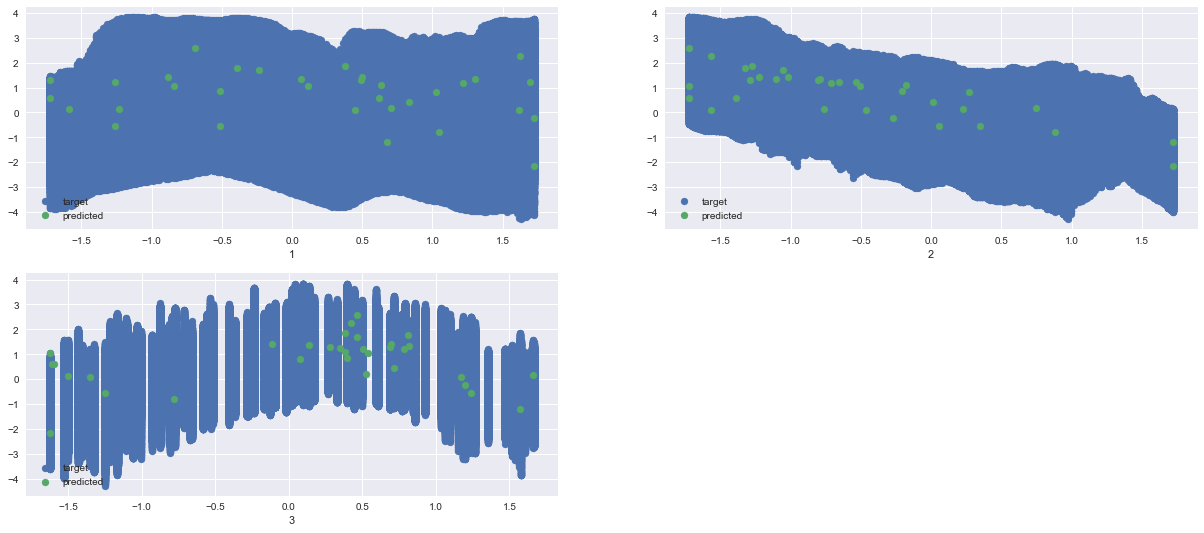

In [14]:
fig = plt.figure(figsize=(21, 9))
for alpha in range(X_data.shape[1]):
    ax = fig.add_subplot(num_dim, num_dim, alpha+1)
    ax.scatter(X_hifi[:,alpha].numpy(), Y_hifi.numpy(),label = 'target')
    ax.scatter(X_lofi[:,alpha].numpy(), Y_lofi.numpy(),label = 'predicted')
    plt.legend(loc="lower left")
    plt.xlabel(f"{alpha+1}")
plt.show()

In [15]:
# Define the Kernel of Gaussian Process
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self,X_train, Y_train,likelihood):
        super(ExactGPModel, self).__init__(X_train, Y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 
       
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)

1 - Iter 100/1000 - Loss: 1.56203 LenghtParam 0.74275
1 - Iter 200/1000 - Loss: 1.54068 LenghtParam 0.79140
1 - Iter 300/1000 - Loss: 1.52412 LenghtParam 0.83762
1 - Iter 400/1000 - Loss: 1.51131 LenghtParam 0.88084
1 - Iter 500/1000 - Loss: 1.50142 LenghtParam 0.92062
1 - Iter 600/1000 - Loss: 1.49380 LenghtParam 0.95660
1 - Iter 700/1000 - Loss: 1.48791 LenghtParam 0.98863
1 - Iter 800/1000 - Loss: 1.48330 LenghtParam 1.01671
1 - Iter 900/1000 - Loss: 1.47964 LenghtParam 1.04098
1 - Iter 1000/1000 - Loss: 1.47666 LenghtParam 1.06166


2 - Iter 100/1000 - Loss: 1.13879 LenghtParam 0.74286
2 - Iter 200/1000 - Loss: 1.11857 LenghtParam 0.79289
2 - Iter 300/1000 - Loss: 1.10062 LenghtParam 0.84295
2 - Iter 400/1000 - Loss: 1.08460 LenghtParam 0.89325
2 - Iter 500/1000 - Loss: 1.07047 LenghtParam 0.94399
2 - Iter 600/1000 - Loss: 1.05824 LenghtParam 0.99544
2 - Iter 700/1000 - Loss: 1.04786 LenghtParam 1.04791
2 - Iter 800/1000 - Loss: 1.03922 LenghtParam 1.10176
2 - Iter 900/1000 - Loss:

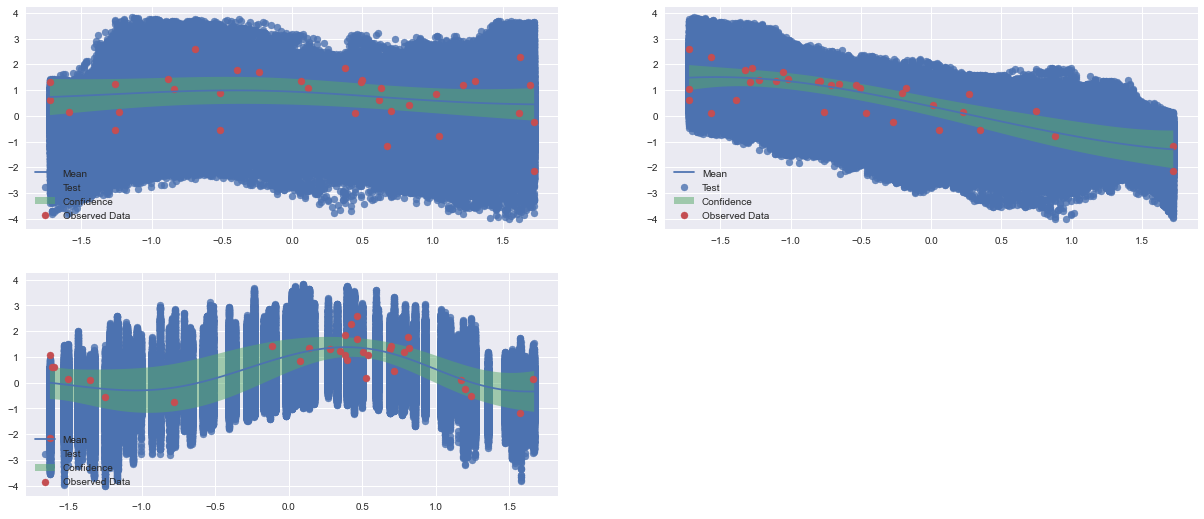

In [16]:
fig = plt.figure(figsize=(21, 9))
for alpha in range(X_data.shape[1]):
# FIT THE MODEL
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    # Define the model
    #gp_model = SingleTaskGP(X_lofi[2:,alpha].unsqueeze(-1) , Y_lofi[2:], likelihood = likelihood  )
    gp_model = ExactGPModel(X_lofi[2:,alpha] , Y_lofi[2:].squeeze(), likelihood)
    # Find optimal model hyperparameters
    gp_model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(gp_model.parameters(),lr=1e-3) # Use the adam optimizer  # Includes GaussianLikelihood parameters
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model) # "Loss" for GPs - the marginal log likelihood
    #mll = gpytorch.mlls.LeaveOneOutPseudoLikelihood(likelihood, gp_model) # "Loss" for GPs - LOO Pseudo likelihood

    training_iter  = 1000 if not SMOKE_TEST else 4
    for i in range(training_iter):
        optimizer.zero_grad()    # Zero gradients from previous iteration
        output = gp_model(X_lofi[2:,alpha])        # Output from model
        loss = -mll(output, Y_lofi[2:].squeeze())     # compute loss and backprop gradients
        loss.backward()
        if (i+1) % 100 == 0:
            print(f'{alpha+1} - Iter {i + 1}/{training_iter} - Loss: {loss.item():.5f} LenghtParam {gp_model.covar_module.base_kernel.lengthscale.detach().numpy()[0,0]:.5f}')
        optimizer.step()
    print('\n')
    
    gp_model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.linspace(X_hifi[:,alpha].min(), X_hifi[:,alpha].max(), 100)
        observed_pred = (gp_model(test_x ))      # Make predictions by feeding model through likelihood
        ax = fig.add_subplot(num_dim, num_dim, alpha+1)      # Initialize plot
        lower, upper = observed_pred.confidence_region()     # Get upper and lower confidence bounds
        ax.scatter(X_test[:,alpha].numpy(), Y_test.numpy(), alpha=0.8, label = 'Test')
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), label = 'Mean')     # Plot predictive means as blue line
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label = 'Confidence')  # Shade between the lower and upper confidence bounds

        ax.scatter(X_lofi[:,alpha].numpy(), Y_lofi.numpy(), s=50,label = 'Observed Data')
        #ax.set_ylim([-4,3])
        ax.legend(loc="lower left")
    # DECREASE VARIANCE
plt.show()